In [159]:
import tensorflow as tf
from tensorflow import keras
tf.__version__

'2.10.0'

In [160]:
keras.__version__

'2.10.0'

## Download the Data

For this example we will work with the "Fashin MNIST" dataset, composed of thousands of $28 \times 28$ images.

In [161]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [162]:
X_train_full.shape

(60000, 28, 28)

In [163]:
X_test.shape

(10000, 28, 28)

Let's visualize the first image of our training set, so we have a better idea of how the data looks like. 

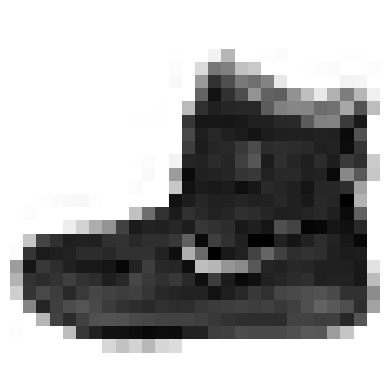

In [164]:
import matplotlib as mlp
import matplotlib.pyplot as plt

sample_image = X_train_full[0]

plt.imshow(sample_image, cmap="binary")
plt.axis("off")
plt.show()

## Define Trainining and Validation Sets

Now let's scale the data by dividing by the maximum value (255), so all the values are in the $[0, 1]$ range.

We will create a validation set from our training set, composed of the first 5000 thousand images, the rest will be used for training.

In [165]:
# X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

In [166]:
print(X_train.shape)
print(X_valid.shape)

(55000, 28, 28)
(5000, 28, 28)


Let's define the names of our classes/categories.

In [167]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", 
               "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [168]:
class_names[y_train[0]]

'Coat'

In [169]:
y_train[0:10]

array([4, 0, 7, 9, 9, 9, 4, 4, 3, 4], dtype=uint8)

## Binary Classifier

In [170]:
import numpy as np

y_ankle = y_train_full[0]
y_train_bin = np.where(y_train == y_ankle, 0, 1)
y_train_bin

array([1, 1, 1, ..., 1, 1, 1])

In [171]:
y_valid_bin = np.where(y_valid == y_ankle, 0, 1)
y_test_bin = np.where(y_test == y_ankle, 0, 1)

## Create the  Model

The input layer has 785 units, which represents the 28 x 28 pixels in the image. Let's define two hidden layers, with 300 and 100 neurons, respecitively. The output layer has 10 units, each representing a class; this output layer uses the `softmax`function to use a multinomial approach to handle multiple classes.

In [172]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28], name="input"),
    keras.layers.Dense(300, activation="sigmoid", name="hidden1"),
    keras.layers.Dense(100, activation="sigmoid", name="hidden2"),
    keras.layers.Dense(1, activation="sigmoid", name="output")
])
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 784)               0         
                                                                 
 hidden1 (Dense)             (None, 300)               235500    
                                                                 
 hidden2 (Dense)             (None, 100)               30100     
                                                                 
 output (Dense)              (None, 1)                 101       
                                                                 
Total params: 265,701
Trainable params: 265,701
Non-trainable params: 0
_________________________________________________________________


We can get an array of the layers in our network with the `layers` propery.

In [173]:
model.layers

We can get an especific layer by index, and access the properties of that layer.

In [174]:
hidden1 = model.layers[1]
hidden1.name

'hidden1'

We also can get a layer by its name with the `get_layer` method.

In [175]:
model.get_layer("hidden1") is hidden1

True

The `get_weights` method returns the weight parameters and bias terms of a layer.

In [176]:
weights, biases = hidden1.get_weights()
weights

array([[ 0.06646881, -0.01292914,  0.04986201, ..., -0.04686245,
         0.00351156, -0.02708911],
       [-0.05719316,  0.02932094,  0.04294334, ...,  0.03775851,
        -0.0699632 ,  0.03168429],
       [-0.05547386, -0.0236292 ,  0.06560589, ..., -0.04187467,
         0.06099258,  0.02143674],
       ...,
       [ 0.00425687,  0.05048473,  0.04456843, ..., -0.05111232,
         0.02372888,  0.04002428],
       [ 0.00693998, -0.00932447,  0.01112469, ...,  0.06034316,
        -0.064955  ,  0.0357217 ],
       [ 0.03471807,  0.03846084,  0.00690506, ...,  0.00571021,
        -0.01373942, -0.0207839 ]], dtype=float32)

In [177]:
print(weights.shape)
print(biases.shape)

(784, 300)
(300,)


## Compile the Model

In this step we specify the loss function, optimizers, and metrics for our network. For this example, we are using the categorical crossentroy loss function, since we are dealing with a multiclass categorical target variable. The `sgd` refers to the "Stochastic Gradiend Descent" algorithm, and we will use the accuracy for measuring the performance of our network. 

In [178]:
model.compile(loss="binary_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

## Adding Callbacks

Callback are helpful to execute periodic specific tasks, for example, at the end of one epoch. In this case, we are adding an "Early Stopping" callback, indicating that if the validation score doesn't improve in 10 epochs, the training will stop and we will get the best solution computed.

In [179]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

You can also define your own callbacks, here we are defining a callback that prints the ration between the validation score and the training score.

In [180]:
class MyCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print(f"\nval/train: {logs['val_loss'] / logs['loss']}")

## Training and Evaluating

To train the network we need to specify the training and validation sets, as well as the number of epochs, callbacks ,and all the necessary parameters.

In [181]:
history = model.fit(X_train, 
                    y_train_bin, 
                    epochs=100, 
                    validation_data=(X_valid, y_valid_bin),
                    callbacks=[early_stopping_cb]
                   )

Epoch 1/100
1719/1719 [==============================] - 2s 908us/step - loss: 0.2695 - accuracy: 0.8982 - val_loss: 0.1875 - val_accuracy: 0.8988
Epoch 2/100
1719/1719 [==============================] - 1s 872us/step - loss: 0.1249 - accuracy: 0.9511 - val_loss: 0.0901 - val_accuracy: 0.9696
Epoch 3/100
1719/1719 [==============================] - 1s 872us/step - loss: 0.0763 - accuracy: 0.9745 - val_loss: 0.0696 - val_accuracy: 0.9722
Epoch 4/100
1719/1719 [==============================] - 1s 872us/step - loss: 0.0643 - accuracy: 0.9762 - val_loss: 0.0622 - val_accuracy: 0.9736
Epoch 5/100
1719/1719 [==============================] - 2s 873us/step - loss: 0.0590 - accuracy: 0.9774 - val_loss: 0.0582 - val_accuracy: 0.9748
Epoch 6/100
1719/1719 [==============================] - 1s 872us/step - loss: 0.0560 - accuracy: 0.9783 - val_loss: 0.0555 - val_accuracy: 0.9760
Epoch 7/100
1719/1719 [==============================] - 2s 880us/step - loss: 0.0538 - accuracy: 0.9792 - val_loss: 0

1719/1719 [==============================] - 1s 866us/step - loss: 0.0334 - accuracy: 0.9877 - val_loss: 0.0325 - val_accuracy: 0.9878
Epoch 57/100
1719/1719 [==============================] - 1s 866us/step - loss: 0.0333 - accuracy: 0.9878 - val_loss: 0.0330 - val_accuracy: 0.9876
Epoch 58/100
1719/1719 [==============================] - 1s 867us/step - loss: 0.0332 - accuracy: 0.9877 - val_loss: 0.0327 - val_accuracy: 0.9876
Epoch 59/100
1719/1719 [==============================] - 1s 868us/step - loss: 0.0329 - accuracy: 0.9883 - val_loss: 0.0337 - val_accuracy: 0.9864
Epoch 60/100
1719/1719 [==============================] - 1s 865us/step - loss: 0.0330 - accuracy: 0.9880 - val_loss: 0.0322 - val_accuracy: 0.9880
Epoch 61/100
1719/1719 [==============================] - 1s 868us/step - loss: 0.0328 - accuracy: 0.9880 - val_loss: 0.0323 - val_accuracy: 0.9874
Epoch 62/100
1719/1719 [==============================] - 2s 881us/step - loss: 0.0327 - accuracy: 0.9879 - val_loss: 0.0322 

With the `epoch` property we get a list with all the epochs that were completed. 

In [182]:
len(history.epoch)

100

The `steps` parameter refers to the number number of steps to complete an epoch, `batch_size * steps = n`. By default the batch size is 32.

In [183]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 1719}

In [184]:
history.history

{'loss': [0.2695257067680359,
  0.1248958483338356,
  0.07634817808866501,
  0.06427951902151108,
  0.05904070660471916,
  0.05596290901303291,
  0.053811512887477875,
  0.05229172855615616,
  0.05100465938448906,
  0.04994119703769684,
  0.04892474412918091,
  0.04803336411714554,
  0.04724544659256935,
  0.04647666960954666,
  0.04576048627495766,
  0.04510057717561722,
  0.04441598057746887,
  0.04387957230210304,
  0.043290115892887115,
  0.042792901396751404,
  0.042272184044122696,
  0.041858453303575516,
  0.041392870247364044,
  0.04090234264731407,
  0.040541451424360275,
  0.040205348283052444,
  0.039828650653362274,
  0.03950323909521103,
  0.03917328640818596,
  0.03882341831922531,
  0.03853675723075867,
  0.03822055086493492,
  0.038023605942726135,
  0.037690967321395874,
  0.03744324669241905,
  0.03720756620168686,
  0.03695417195558548,
  0.0366806834936142,
  0.03647635877132416,
  0.036282915621995926,
  0.03596533089876175,
  0.035904910415410995,
  0.035638827830

We can use the `history` property to obtain the score and loss of the training and validation sets.

<function matplotlib.pyplot.show(close=None, block=None)>

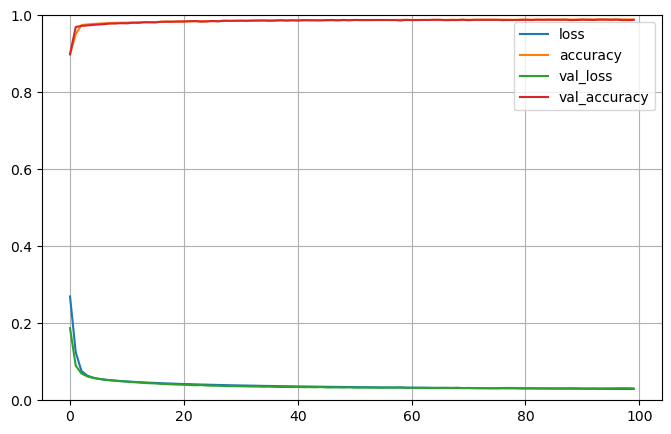

In [185]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show

We use the `evaluate` method to measure the performance of a given data set. Below we display the loss and accuracy of the test set.

Both, the accuracy and the loss are similar to the validation set, which is a sign that we aren't overfitting the training data.

In [186]:
model.evaluate(X_test, y_test_bin)

313/313 [==============================] - 0s 535us/step - loss: 0.0318 - accuracy: 0.9881


[0.031798988580703735, 0.988099992275238]

In [187]:
y_ankle

9

In [188]:
y_test[:10]

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7], dtype=uint8)

In [189]:
y_test_bin[:10]

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

The `predict` method returns the output of a forward step through the network with the given input. For this example, since we are using the `softmax` activation function; we get the probabilities to belong to each class.

In [199]:
X_new = X_test[:10]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 19ms/step


array([[0.33],
       [1.  ],
       [1.  ],
       [1.  ],
       [1.  ],
       [1.  ],
       [1.  ],
       [1.  ],
       [1.  ],
       [1.  ]], dtype=float32)

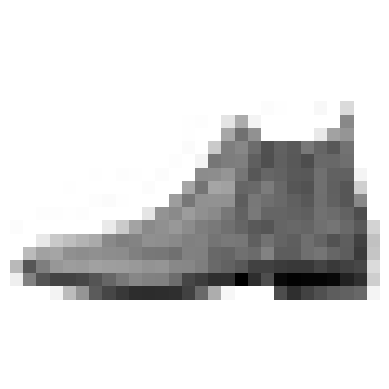

In [200]:
plt.imshow(X_test[0], cmap="binary")
plt.axis("off")
plt.show()